In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization, ReLU
from keras.layers import Dropout, Dense, TimeDistributed, Reshape, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
!pip install --upgrade scikit-learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

2024-05-04 04:56:07.119550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 04:56:07.119648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 04:56:07.259660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 86.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CLASSES = 7

In [21]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/tess-full/TESS/Mel_Spectrograms/Train',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/tess-full/TESS/Mel_Spectrograms/Test',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

Found 8960 files belonging to 7 classes.
Found 560 files belonging to 7 classes.


In [3]:
# Make a dataset containing the training spectrograms
total_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory='/kaggle/input/savee-full/SAVEE/Mel_Spectrograms/Complete',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory='/kaggle/input/savee-full/SAVEE/Mel_Spectrograms/Complete',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

# Split the train_dataset into training and validation subsets
train_dataset_size = len(total_train_dataset)
train_size = int(0.7 * train_dataset_size)
valid_size = train_dataset_size - train_size

# Take the first train_size elements for training
train_dataset = total_train_dataset.take(train_size)

# Skip the first train_size elements to get the remaining for validation
valid_dataset = total_train_dataset.skip(train_size).take(valid_size)

Found 1920 files belonging to 7 classes.
Using 1344 files for training.
Found 1920 files belonging to 7 classes.
Using 576 files for validation.


In [22]:
def get_crnnd_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Reshape((-1, 128)))
  model.add(LSTM(128, dropout=0.5, return_sequences=True))
  model.add(LSTM(128, dropout=0.5, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(256, activation='relu')))
  model.add(TimeDistributed(Dense(128, activation='relu')))
  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(Flatten())
  model.add(Dense(7, activation = 'softmax'))
  model.summary()
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001), metrics = ['acc'])
  return model

In [23]:
model_name = 'CRNN'
model = get_crnnd_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 256, 256)       │        33,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 256, 128)       │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 256, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │       114,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 546,183 (2.08 MB)

 Trainable params: 545,735 (2.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, callbacks = [early_stopping], verbose = 1)
# history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, verbose = 1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 250s 761ms/step - acc: 0.4303 - loss: 1.3910 - val_acc: 0.9536 - val_loss: 0.1427
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 204s 727ms/step - acc: 0.9767 - loss: 0.0784 - val_acc: 0.9911 - val_loss: 0.0239
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 204s 725ms/step - acc: 0.9914 - loss: 0.0254 - val_acc: 0.9982 - val_loss: 0.0055
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 204s 727ms/step - acc: 0.9931 - loss: 0.0210 - val_acc: 0.9946 - val_loss: 0.0142
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 204s 729ms/step - acc: 0.9965 - loss: 0.0097 - val_acc: 0.9982 - val_loss: 0.0069
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 723ms/step - acc: 0.9974 - loss: 0.0075 - val_acc: 0.9911 - val_loss: 0.0368
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 723ms/step - acc: 0.9962 - loss: 0.0103 - val_acc: 0.9964 - val_loss: 0.0191
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 723ms/step - acc: 0.9984 - loss: 0.0057 - val_acc: 0.9964 - val_loss: 0.0123


In [26]:
model.save("SAVEE_CRNN_COMP.h5")

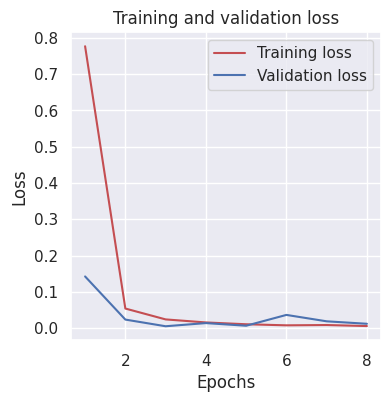

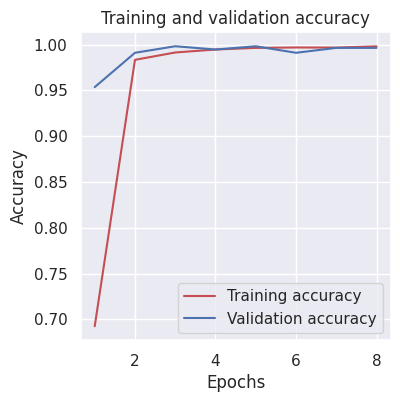

Training Results:
Final loss: 0.002148, final accuracy: 0.999442
Validation Results:
Final loss: 0.010181, final accuracy: 0.998214
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        80
     Disgust       1.00      1.00      1.00        80
        Fear       1.00      1.00      1.00        80
       Happy       1.00      0.99      0.99        80
     Neutral       1.00      1.00      1.00        80
         Sad       1.00      1.00      1.00        80
    Surprise       0.99      1.00      0.99        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



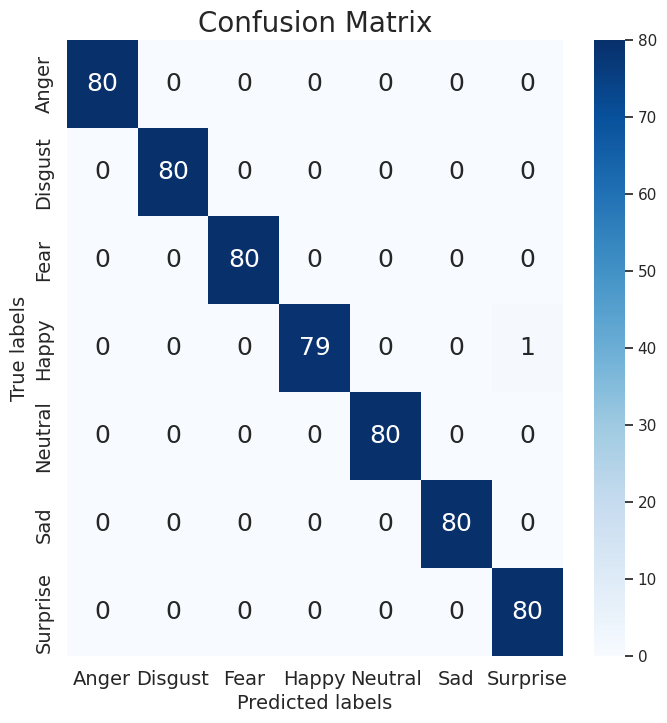

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set()

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
    
plt.figure(figsize=(4,4))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation.
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(4,4))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(train_dataset, verbose=0)
print("Training Results:")
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Validation Results:")
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

# Assuming `test_dataset` contains your test data and labels, and `model` is your trained Keras model
test_images = []
test_labels = []
for images, labels in valid_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Get model predictions on the test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(test_labels, y_pred, target_names=class_names)

# Print the classification report
print('Classification Report:')
print(report)

# Plot the confusion matrix using Seaborn's heatmap function

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=class_names, yticklabels=class_names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('True labels', size=14)
plt.show()